In [6]:
from fastai.text import *
import html

In [7]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
PATH=Path('data/toxic-comments/')

In [8]:
chunksize=24000
classes=['toxic','severe_toxic','obscene','threat','insult','identity_hate']

# Data Preparation

In [5]:
df_train = pd.read_csv(PATH/'train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_test = pd.read_csv(PATH/'test.csv')
len(df_test),len(df_train)

(153164, 159571)

In [8]:
np.random.seed(42)
trn_idx = np.random.permutation(len(df_train))
val_idx = np.random.permutation(len(df_test))

trn_texts = df_train.iloc[trn_idx]['comment_text']
val_texts = df_test.iloc[val_idx]['comment_text']
trn_texts.head()

119105    Geez, are you forgetful!  We've already discus...
131631    Carioca RFA \n\nThanks for your support on my ...
125326    "\n\n Birthday \n\nNo worries, It's what I do ...
111256    Pseudoscience category? \n\nI'm assuming that ...
83590     (and if such phrase exists, it would be provid...
Name: comment_text, dtype: object

In [9]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [10]:
len(trn_texts), len(val_texts)

(281461, 31274)

In [31]:
def get_df(texts):
    trn_dict = {'text':texts}
    trn_dict.update({cls: [0]*len(texts) for cls in classes})
    return pd.DataFrame(trn_dict, columns=classes+['text'])

df_trn = get_df(trn_texts)
df_val = get_df(val_texts)

len(df_trn),len(df_val)

(281461, 31274)

In [32]:
df_trn.to_csv(PATH/'train_lm.csv', header=False, index=False)
df_val.to_csv(PATH/'test_lm.csv', header=False, index=False)

In [12]:
df_trn = pd.read_csv(PATH/'train_lm.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(PATH/'test_lm.csv', header=None, chunksize=chunksize)

In [14]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [9]:
df_trn.head()

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,And BTW 18th Century means 1700-1799
1,0,0,0,0,0,0,""" \n |} \n :The new tools are great! Thanks! ..."
2,0,0,0,0,0,0,:I would love to get involved. I actually agre...
3,0,0,0,0,0,0,""" \n :Done, thanks, ''' (') """
4,0,0,0,0,0,0,"*Again, you have been temporarily blocked from..."


In [15]:
tok_trn, trn_labels = get_all(df_trn, len(classes))
tok_val, val_labels = get_all(df_val, len(classes))

0
1
2
3
4
5
6
7
8
9
10
0
1


In [16]:
np.save(PATH/'tok_trn_lm.npy', tok_trn)
np.save(PATH/'tok_val_lm.npy', tok_val)

In [17]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 790553),
 ('the', 754857),
 (',', 715875),
 ('"', 613047),
 ('to', 442914),
 ('t_up', 374219),
 ('i', 353924),
 ('and', 337087),
 ('of', 336736),
 ('a', 334611),
 ('\n', 328012),
 ('you', 322127),
 ('is', 281559),
 ('1', 265129),
 ('xbos', 257461),
 ('xfld', 257461),
 ('that', 244308),
 ('it', 228125),
 ('in', 220728),
 (':', 198466),
 ('=', 162474),
 ('for', 152637),
 ('this', 148474),
 ('not', 143216),
 ('-', 142895)]

In [18]:
max_vocab = 60000
min_freq = 2

In [19]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [20]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [21]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [22]:
np.save(PATH/'trn_ids_lm.npy', trn_lm)
np.save(PATH/'val_ids_lm.npy', val_lm)
pickle.dump(itos, open(PATH/'itos_lm.pkl', 'wb'))

In [23]:
vs=len(itos)
vs,len(trn_lm)

(60002, 257461)

# Download pretrained model

In [24]:
! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-07-22 16:50:26--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/toxic-comments/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-07-22 16:50:27 (139 MB/s) - ‘data/toxic-comments/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-07-22 16:50:27--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-07-22 16:50:27 ERROR 404: Not Found.

--2018-07-22 16:50:27--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/toxic-comments/models/wt103/index.html?C=N;O=D’

mo

In [4]:
em_sz,nh,nl = 400,1150,3
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [5]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [6]:
itos_pretrained = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi_pretrained = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos_pretrained)})

In [11]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi_pretrained[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [12]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Set up new language model

In [8]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [9]:
trn_lm = np.load(PATH/'trn_ids_lm.npy')
val_lm = np.load(PATH/'val_ids_lm.npy')
itos = pickle.load(open(PATH/'itos_lm.pkl', 'rb'))

In [10]:
vs=len(itos)
vs,len(trn_lm)

(60002, 257461)

In [13]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [14]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 0.7

In [15]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)
learner.model.load_state_dict(wgts)

In [18]:
learner.model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [20]:
lr=1e-3

In [20]:
learner.lr_find(start_lr=lr/10, end_lr=lr*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.5028     4.210571   0.301018  



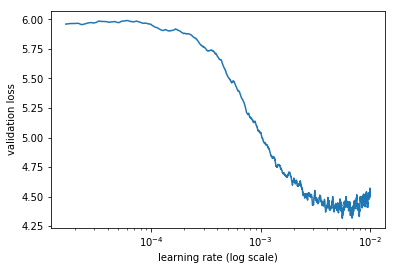

In [21]:
learner.sched.plot()

In [28]:
learner.fit(lr, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.441988   4.186282   0.299148  



[array([4.18628]), 0.2991481918598647]

In [29]:
learner.save('lm_lastlayer')

In [16]:
learner.load('lm_lastlayer')

In [17]:
learner.unfreeze()

In [21]:
learner.lr_find(start_lr=lr/10, end_lr=lr*10, linear=True)

epoch      trn_loss   val_loss   accuracy                       
    0      4.366402   4.225931   0.314858  



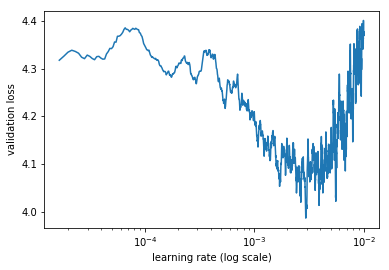

In [22]:
learner.sched.plot()

In [ ]:
learner.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=15)

 49%|████▉     | 2957/6060 [33:04<34:42,  1.49it/s, loss=4.04] 

In [26]:
learner.save('lm_finetuned')

In [27]:
learner.save_encoder('lm_enc_finetuned')

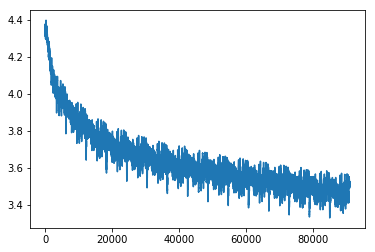

In [29]:
learner.sched.plot_loss()

# Classifier data

In [63]:
df_train = pd.read_csv(PATH/'train.csv')
df_test = pd.read_csv(PATH/'test.csv')

In [64]:
np.random.seed(42)
trn_idx = np.random.permutation(len(df_train))
val_idx = np.random.permutation(len(df_test))

trn_texts = df_train.iloc[trn_idx]['comment_text']
val_texts = df_test.iloc[val_idx]['comment_text']

In [65]:
def get_df(texts):
    trn_dict = {'text':texts}
    trn_dict.update({cls: df_train.iloc[trn_idx][cls] for cls in classes})
    return pd.DataFrame(trn_dict, columns=classes+['text'])

df_trn = get_df(trn_texts)
df_val = get_df(val_texts)

len(df_trn),len(df_val)

(159571, 159571)

In [66]:
df_trn.to_csv(PATH/'train_cls.csv', header=False, index=False)
df_val.to_csv(PATH/'test_cls.csv', header=False, index=False)

In [67]:
df_trn = pd.read_csv(PATH/'train_cls.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(PATH/'test_cls.csv', header=None, chunksize=chunksize)

In [68]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [69]:
tok_trn, trn_labels = get_all(df_trn, len(classes))
tok_val, val_labels = get_all(df_val, len(classes))

0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [70]:
np.save(PATH/'tok_trn_cls.npy', tok_trn)
np.save(PATH/'tok_val_cls.npy', tok_val)

In [71]:
np.save(PATH/'trn_labels_cls.npy', trn_labels)
np.save(PATH/'val_labels_cls.npy', val_labels)

In [72]:
itos = pickle.load(open(PATH/'itos_lm.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [73]:
trn_cls = np.array([[stoi[o] for o in p] for p in tok_trn])
val_cls = np.array([[stoi[o] for o in p] for p in tok_val])

In [21]:
np.save(PATH/'trn_ids_cls.npy', trn_cls)
np.save(PATH/'val_ids_cls.npy', val_cls)

# Classifier

In [22]:
itos = pickle.load(open(PATH/'itos_lm.pkl', 'rb'))
tok_trn = np.load(PATH/'tok_trn_cls.npy')
tok_val = np.load(PATH/'tok_val_cls.npy')
trn_labels = np.load(PATH/'trn_labels_cls.npy')
val_labels = np.load(PATH/'val_labels_cls.npy')
trn_cls = np.load(PATH/'trn_ids_cls.npy')
val_cls = np.load(PATH/'val_ids_cls.npy')

In [10]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48
wd=1e-7

In [11]:
trn_ds = TextDataset(trn_cls, trn_labels)
val_ds = TextDataset(val_cls, val_labels)
trn_samp = SortishSampler(trn_cls, key=lambda x: len(trn_cls[x]), bs=bs//2)
val_samp = SortSampler(val_cls, key=lambda x: len(val_cls[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [12]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [13]:
c = len(classes)
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [14]:
m

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=6, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1

In [18]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn, crit=nn.CrossEntropyLoss(reduce=False))
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm_enc_finetuned')
learn.freeze_to(-1)

In [19]:
lr=1e-3

In [20]:
learn.fit(lr, 1, wds=wd, cycle_len=1, use_clr=(8,3))

  0%|          | 0/6649 [00:00<?, ?it/s]


RuntimeError: multi-target not supported at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THCUNN/generic/ClassNLLCriterion.cu:16